### Problem Statement
- The given problem is to classify between text image and no text image.
- We will leverage the magic of Deep Learning to complete this task.

###  Data Description
- We have 5,875 RGB images of size 64x64 (train).
- We have 98 RGB test images.

### Goal
- The goal is to create deep learning models to predict the class(text and no text).
- Create a JSON file with prediction of test images.

### Business Constraint
- Latancy is not an issue considering end user requirement.

## Importing Library

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
for device in tf.config.get_visible_devices('GPU'):
    tf.config.experimental.set_memory_growth(device, True)
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, load_img, img_to_array
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import *
from tensorflow.keras.initializers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications import *
import tensorflow.keras.losses as losses
import imgaug.augmenters as iaa
from tqdm import tqdm
import cv2
import json
import os
import re
from skimage.io import *
from skimage.transform import resize
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
tf.config.experimental_run_functions_eagerly(True)

### Data Directories and Image dimensions

In [2]:
train_dir = 'training/'
img_h, img_w = 64, 64
dim = (img_h, img_w, 3)
bs = 64

#### Filtering the augumentated images fro non-augumented images:
- Doing this will avoid overfitting of model

In [3]:
X_train, X_val, y_train, y_val = [], [], [], []
for class_ in tqdm(os.listdir(train_dir)):
    path_ = os.path.join(train_dir, class_)
    for file in os.listdir(path_):
        path = os.path.join(path_, file)
        img = imread(path)
        if len(re.findall('_none_none', file)) != 0:
            X_val.append(img)
            y_val.append(class_)
        
        else:
            X_train.append(img)
            y_train.append(class_)
                   
X_train = np.array(X_train)
y_train = np.array(y_train)
y_train = (y_train == 'hi').astype("int32")

X_val = np.array(X_val)
y_val = np.array(y_val)
y_val = (y_val == 'hi').astype("int32")

print(X_train.shape, X_val.shape)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.95s/it]

(5459, 64, 64, 3) (416, 64, 64, 3)


## Loading Images

In [4]:
bs = 64
train_gen = ImageDataGenerator(rescale = 1/255)

val_gen = ImageDataGenerator(rescale = 1/255)

train = train_gen.flow(X_train, y_train, batch_size = bs)

val = val_gen.flow(X_val, y_val, batch_size = 32)

## Sample Output of Images

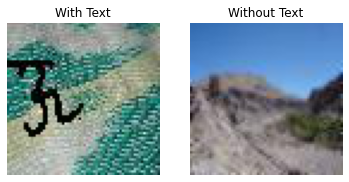

In [51]:
samp_x, samp_y = next(train)
fig, ax = plt.subplots(1, 2)
text = samp_y.tolist().index(1)
no_text = samp_y.tolist().index(0)
ax[0].imshow(samp_x[text])
ax[0].axis('off')
ax[0].set_title('With Text')
ax[1].imshow(samp_x[no_text])
ax[1].axis('off')
ax[1].set_title('Without Text')
plt.show()

## Model Architecture

In [5]:
inp = Input((dim), name = 'Input')
model = Sequential()
model.add(inp)
for filt in [256, 128, 64, 32, 16]:
    model.add(Conv2D(filters = filt, kernel_size = 3, padding = 'same', activation = 'relu' , dilation_rate = 1))
    model.add(Conv2D(filters = filt, kernel_size = 3, padding = 'same', activation = 'relu', dilation_rate = 2))
    model.add(Conv2D(filters = filt, kernel_size = 3, padding = 'same', activation = 'relu', dilation_rate = 3))
    model.add(MaxPool2D(2))

model.add(GlobalMaxPool2D())

model.add(Dense(units = 1, activation = 'sigmoid', name = 'Output'))

model.compile('adam', 'binary_crossentropy', 'accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 256)       7168      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 256)       590080    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 256)       590080    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       295040    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 128)       1

tf.keras.utils.plot_model(model_1, show_shapes=True)

## Training Model

In [6]:
check = ModelCheckpoint('model_1.h5', save_best_only = True)
early = EarlyStopping(patience = 2, restore_best_weights = True)
model.fit(train, epochs = 100, validation_data = (val), steps_per_epoch = train.n//bs,
              callbacks = [check], validation_steps = val.n//bs)

Epoch 1/100
85/85 [==============================] - 40s 470ms/step - loss: 0.5757 - accuracy: 0.7514 - val_loss: 0.5546 - val_accuracy: 0.7552
Epoch 2/100
85/85 [==============================] - 35s 413ms/step - loss: 0.3625 - accuracy: 0.8571 - val_loss: 0.1847 - val_accuracy: 0.9010
Epoch 3/100
85/85 [==============================] - 35s 413ms/step - loss: 0.2599 - accuracy: 0.9025 - val_loss: 0.2071 - val_accuracy: 0.8802
Epoch 4/100
85/85 [==============================] - 35s 413ms/step - loss: 0.1814 - accuracy: 0.9331 - val_loss: 0.0576 - val_accuracy: 0.9948
Epoch 5/100
85/85 [==============================] - 35s 409ms/step - loss: 0.1990 - accuracy: 0.9331 - val_loss: 0.1070 - val_accuracy: 0.9688
Epoch 6/100
85/85 [==============================] - 35s 409ms/step - loss: 0.1580 - accuracy: 0.9431 - val_loss: 0.0910 - val_accuracy: 0.9844
Epoch 7/100
85/85 [==============================] - 35s 410ms/step - loss: 0.1036 - accuracy: 0.9629 - val_loss: 0.0609 - val_accuracy:

Epoch 57/100
85/85 [==============================] - 35s 407ms/step - loss: 0.0141 - accuracy: 0.9957 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 58/100
85/85 [==============================] - 36s 421ms/step - loss: 0.0060 - accuracy: 0.9981 - val_loss: 0.0119 - val_accuracy: 0.9948
Epoch 59/100
85/85 [==============================] - 34s 405ms/step - loss: 0.0176 - accuracy: 0.9941 - val_loss: 0.0624 - val_accuracy: 0.9948
Epoch 60/100
85/85 [==============================] - 35s 407ms/step - loss: 0.0043 - accuracy: 0.9987 - val_loss: 0.0314 - val_accuracy: 0.9896
Epoch 61/100
85/85 [==============================] - 35s 406ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 2.3270e-05 - val_accuracy: 1.0000
Epoch 62/100
85/85 [==============================] - 35s 407ms/step - loss: 0.0010 - accuracy: 0.9996 - val_loss: 8.5770e-06 - val_accuracy: 1.0000
Epoch 63/100
85/85 [==============================] - 35s 408ms/step - loss: 5.2782e-04 - accuracy: 0.9998 - val_loss: 0.0

## Model Evaluating and Visualization

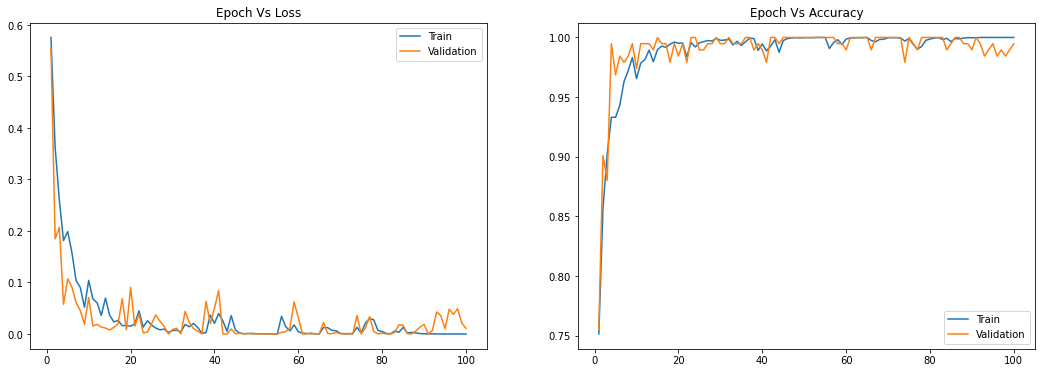

In [7]:
fig, ax = plt.subplots(1, 2)

train_losses, val_losses = model.history.history['loss'], model.history.history['val_loss']
train_acc, val_acc = model.history.history['accuracy'], model.history.history['val_accuracy']
ax[0].plot(list(range(1, len(train_losses)+1)), train_losses, label = 'Train')
ax[0].plot(list(range(1, len(train_losses)+1)), val_losses, label = 'Validation')
ax[0].legend()
ax[0].set_title('Epoch Vs Loss')

ax[1].plot(list(range(1, len(train_losses)+1)), train_acc, label = 'Train')
ax[1].plot(list(range(1, len(train_losses)+1)), val_acc, label = 'Validation')
ax[1].legend()
ax[1].set_title('Epoch Vs Accuracy')
fig.set_figheight(6)
fig.set_figwidth(18)
plt.show()

In [10]:
model.evaluate(val)

13/13 [==============================] - 1s 71ms/step - loss: 3.3684e-04 - accuracy: 1.0000


[0.0003368360921740532, 1.0]

In [3]:
model = load_model('model_1.h5')

In [5]:
result = {}
files = os.listdir('test')
for file in files:
    path = os.path.join('test', file)
    img = imread(path)/255
    img = np.expand_dims(img, 0)
    pred = (model.predict(img) > 0.5).astype("int32")[0][0]
    result[file] = int(pred)
json.dump(result, open('result.json', 'w'))